In [145]:
import deepctx as dc
from dnadb import dna, fasta, sample
import matplotlib.colors as mpc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import auc, precision_recall_curve, roc_curve, precision_recall_fscore_support, precision_score, recall_score
import tensorflow as tf
from tqdm import tqdm
import wandb

In [6]:
from deepdna.nn.data_generators import SampleValueTargetGenerator
from deepdna.nn.metrics import f1_score, positive_predictive_value, negative_predictive_value
from deepdna.nn.models import load_model, setbert

In [7]:
dc.tf.devices.use(gpus=[0])

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
samples = sample.load_multiplexed_fasta(
    "/home/dwl2x/work/Datasets/SFD/SFD.fasta.db",
    "/home/dwl2x/work/Datasets/SFD/SFD.fasta.mapping.db",
    "/home/dwl2x/work/Datasets/SFD/SFD.fasta.index.db")

In [9]:
len(samples)

737

In [10]:
targets = {}
with open("/home/dwl2x/work/Datasets/SFD/SFD.pathogen_load.tsv") as f:
    f.readline()
    for line in f:
        key, value = line.strip().split()
        targets[key] = int(float(value) != 0.0)

In [11]:
len(targets)

737

In [12]:
positive_samples = [s for s in samples if targets[s.name] == 1]
negative_samples = [s for s in samples if targets[s.name] == 0]

In [13]:
len(positive_samples), len(negative_samples)

(190, 547)

In [53]:
def compute_class_weights(samples, targets):
    negative_indices = np.array([1.0 if targets[sample.name] == 0.0 else 0.0 for sample in samples])
    positive_indices = 1 - negative_indices
    negative_weights = negative_indices / np.sum(negative_indices)
    positive_weights = positive_indices / np.sum(positive_indices)
    class_weights = positive_weights/2 + negative_weights/2
    return class_weights

In [54]:
class_weights = compute_class_weights(samples, targets)

In [55]:
common_args = dict(
    samples=samples,
    sample_values=targets,
    sequence_length=150,
    kmer=3,
    subsample_size=1000,
    batch_size=3,
    class_weights=class_weights
)

train_data = SampleValueTargetGenerator(
    batches_per_epoch=100,
    **common_args
)
    
val_data = SampleValueTargetGenerator(
    batches_per_epoch=20,
    shuffle=False,
    **common_args
)

In [3]:
train_data[0][1]

NameError: name 'train_data' is not defined

In [73]:
batches = list(train_data)

In [76]:
sum(sum(b[1]) for b in batches)

158.0

In [79]:
y_pred = []
y_true = []
for b in tqdm(batches):
    y_pred.append(model(b[0]))
    y_true.append(b[1])
y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


In [88]:
np.sum((y_pred >= 0.5).astype(np.int32) == y_true.astype(np.int32))

267

In [77]:
model.evaluate(train_data)

100/100 [==============================] - 60s 604ms/step - loss: 0.2772 - binary_accuracy: 0.8900 - precision_ppv: 0.8698 - recall: 0.9304 - f1_score: 0.7870 - negative_predictive_value: 0.7783


[0.2771616578102112,
 0.8899999856948853,
 0.8698225021362305,
 0.9303797483444214,
 0.7869998812675476,
 0.778333306312561]

In [16]:
run = wandb.init(project="snake-fungal-disease", id="g69qeaji", resume="must")

wandb: Currently logged in as: sirdavidludwig. Use `wandb login --relogin` to force relogin


In [12]:
path = run.use_artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-synthetic-64d-150l:v0").download()
setbert_pretrained = load_model(path, setbert.SetBertPretrainModel)

wandb: Downloading large artifact setbert-pretrain-synthetic-64d-150l:v0, 58.35MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.2
2023-10-03 02:01:51.258571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 02:01:51.747099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78969 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:0b:00.0, compute capability: 8.0


In [13]:
encoder = setbert.SetBertEncoderModel(
    setbert_pretrained.base,
    compute_sequence_embeddings=True,
    stop_sequence_embedding_gradient=False
)

In [14]:
x = encoder.input
y = encoder.output
# out1 = tf.keras.layers.Dense(1, activation="relu", name="pathogen_load")(y)
out2 = tf.keras.layers.Dense(1, activation="sigmoid", name="fungus_present")(y)
model = tf.keras.Model(x, out2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision_ppv"),
        tf.keras.metrics.Recall(),
        f1_score,
        negative_predictive_value
    ]
)

In [15]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 148)]       0         
                                                                 
 chunked_embedding_layer_1 (  (None, None, None)       1210496   
 ChunkedEmbeddingLayer)                                          
                                                                 
 set_bert_model (SetBertMode  (None, None, 64)         2340672   
 l)                                                              
                                                                 
 split_class_token_1 (SplitC  ((None, 64),             0         
 lassToken)                   (None, None, 64))                  
                                                                 
 fungus_present (Dense)      (None, 1)                 65        
                                                           

In [18]:
model = load_model(run.dir + "/model")

2023-10-04 00:43:07.365905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 00:43:09.579786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78969 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:0b:00.0, compute capability: 8.0


In [56]:
model.fit(
    train_data,
    validation_data=val_data,
    epochs=350,
    initial_epoch=201,
    callbacks=[
        wandb.keras.WandbMetricsLogger(),
        tf.keras.callbacks.ModelCheckpoint(Path(run.dir) / "model")
    ]
)

INFO:tensorflow:Assets written to: /home/dwl2x/.cache/wandb/wandb/run-20231004_004134-g69qeaji/files/model/assets


INFO:tensorflow:Assets written to: /home/dwl2x/.cache/wandb/wandb/run-20231004_004134-g69qeaji/files/model/assets


100/100 [==============================] - 261s 3s/step - loss: 0.1331 - binary_accuracy: 0.9500 - precision_ppv: 0.9470 - recall: 0.9533 - f1_score: 0.8567 - negative_predictive_value: 0.8417 - val_loss: 0.1269 - val_binary_accuracy: 0.9500 - val_precision_ppv: 0.9375 - val_recall: 0.9677 - val_f1_score: 0.9133 - val_negative_predictive_value: 0.8500


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 302/350
  4/100 [>.............................] - ETA: 2:38 - loss: 0.1868 - binary_accuracy: 0.9167 - precision_ppv: 0.8571 - recall: 1.0000 - f1_score: 0.9500 - negative_predictive_value: 0.7500


KeyboardInterrupt



In [59]:
rng = np.random.default_rng()

In [60]:
y_true = []
y_pred = []
for s in tqdm(samples):
    sequences = []
    for entry in s.sample(1000):
        offset = rng.integers(len(entry.sequence) - 150)
        sequences.append(dna.encode_sequence(entry.sequence[offset:150+offset]))
    sequences = dna.encode_kmers(np.array(sequences), 3)
    y_pred.append(model(np.expand_dims(sequences, 0)))
    y_true.append(targets[s.name])
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

100%|██████████| 737/737 [03:09<00:00,  3.89it/s]


Text(0.5, 1.0, 'Precision-Recall Curve')

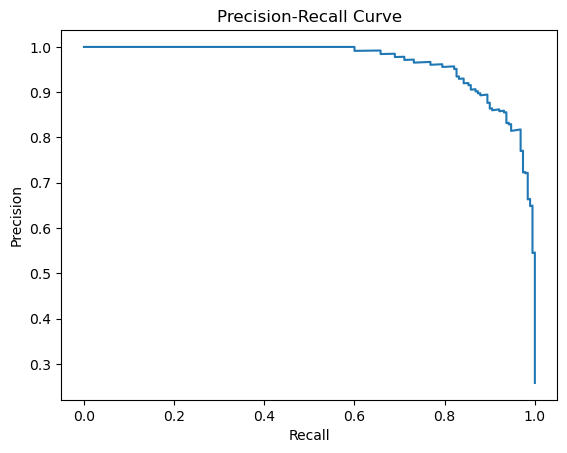

In [84]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

Text(0.5, 1.0, 'ROC Curve')

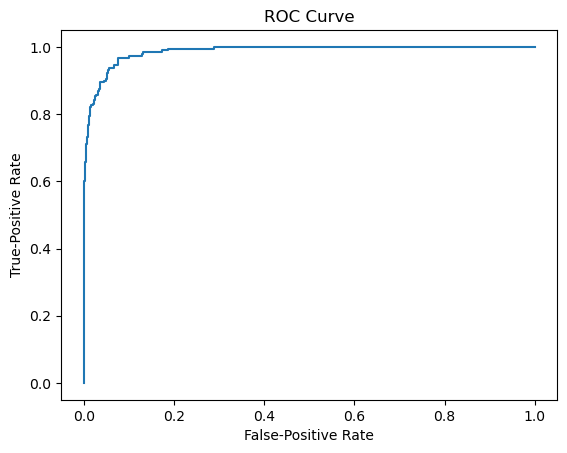

In [62]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve")

In [63]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [64]:
thresholds = y_pred.copy()

In [65]:
ppv_points = []
npv_points = []
for threshold in thresholds:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > threshold).ravel()
    ppv_points.append(tp / (tp + fp))
    npv_points.append(tn / (tn + fn))
ppv_points, npv_points = np.array(ppv_points), np.array(npv_points)

/tmp/ipykernel_860688/1849567560.py:5: RuntimeWarning: invalid value encountered in long_scalars
  ppv_points.append(tp / (tp + fp))


In [66]:
indices = np.argsort(npv_points)
ppv_points = ppv_points[indices]
npv_points = npv_points[indices]
thresholds = thresholds[indices]

ppv_points[0] = 1.0
ppv_points = np.concatenate(([1.0], ppv_points))
npv_points = np.concatenate(([0.0], npv_points))

In [67]:
closest_index = -1
closest = np.inf
for i in range(len(npv_points)):
    d = abs(npv_points[i] - 0.903)
    if d < closest:
        closest_index = i
        closest = d

In [68]:
print("Our Model NPV:", npv_points[closest_index])
print("Our Model PPV:", ppv_points[closest_index])

Our Model NPV: 0.9036544850498339
Our Model PPV: 0.9777777777777777


In [69]:
thresholds[closest_index]

0.9589245

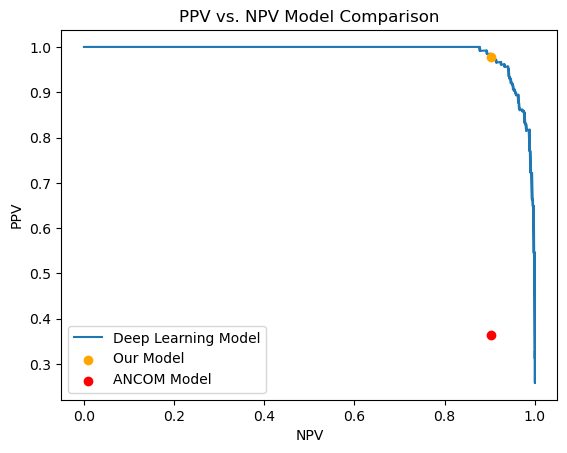

In [70]:
plt.title("PPV vs. NPV Model Comparison")
plt.plot(npv_points, ppv_points, label="Deep Learning Model")
# plt.scatter([npv_points[i]], [ppv_points[i]], color="green", zorder=2, label="ANCOM Model")
plt.scatter(npv_points[closest_index], ppv_points[closest_index], color="orange", zorder=2, label="Our Model")
plt.scatter([0.903], [0.364], color="red", zorder=2, label="ANCOM Model")
plt.ylabel("PPV")
plt.xlabel("NPV")
plt.legend()
# ppv_points[i], npv_points[i], thresholds[i]
plt.savefig("./model_comparison.png", dpi=300, format="png")

In [83]:
precision, recall, fbeta, support = precision_recall_fscore_support(y_true, (y_pred > 0.95).astype(np.int64))
precision, recall, fbeta, support

(array([0.91414141, 0.97202797]),
 array([0.99268739, 0.73157895]),
 array([0.95179667, 0.83483483]),
 array([547, 190]))

In [94]:
x = model.layers[0].input
y, _ = model.layers[-2].output
encoder = tf.keras.Model(x, y)

In [104]:
positive_embeddings = []
negative_embeddings = []
for s in tqdm(samples):
    batch = []
    for i in range(3):
        sequences = []
        for entry in s.sample(1000):
            offset = rng.integers(len(entry.sequence) - 150)
            sequences.append(dna.encode_sequence(entry.sequence[offset:150+offset]))
        sequences = dna.encode_kmers(np.array(sequences), 3)
        batch.append(sequences)
    batch = np.array(batch)
    embeddings = encoder(batch)
    if targets[s.name]:
        positive_embeddings.append(embeddings)
    else:
        negative_embeddings.append(embeddings)

100%|██████████| 737/737 [08:10<00:00,  1.50it/s]


In [105]:
positive_embeddings = np.array(positive_embeddings)
negative_embeddings = np.array(negative_embeddings)

In [111]:
positive_embeddings = positive_embeddings.reshape((-1, 64))

In [109]:
negative_embeddings = negative_embeddings.reshape((-1, 64))

In [118]:
embeddings = np.concatenate((positive_embeddings, negative_embeddings), axis=0)

In [113]:
from sklearn.manifold import MDS

In [114]:
from scipy.spatial.distance import cdist

In [120]:
d = cdist(embeddings, embeddings, metric="cityblock")

In [121]:
d.shape

(2211, 2211)

In [125]:
mds = MDS(2, dissimilarity="precomputed")
p = mds.fit_transform(d)

In [126]:
p.shape

(2211, 2)

In [178]:
heat = []
for s in positive_samples:
    heat.append(pathogen_loads[s.name])
for s in negative_samples:
    heat.append(pathogen_loads[s.name])
heat = np.array(heat)
max_heat = np.max(heat)

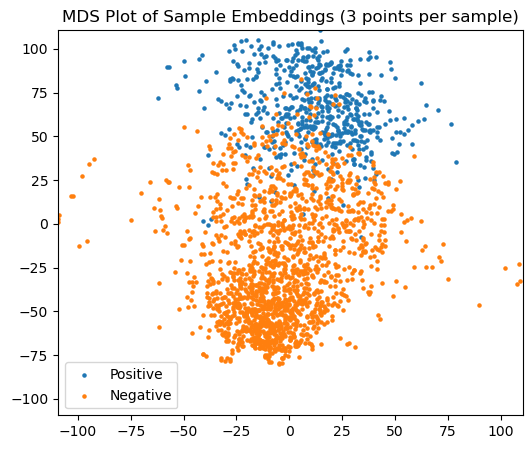

In [169]:
minimum, maximum = np.min(p), np.max(p)
plt.figure(figsize=(6, 5))
plt.title("MDS Plot of Sample Embeddings (3 points per sample)")
plt.scatter(*p[:len(positive_embeddings)].T, label="Positive", s=5)
plt.scatter(*p[len(positive_embeddings):].T, label="Negative", s=5)
plt.xlim((minimum, maximum))
plt.ylim(minimum, maximum)
plt.legend()
plt.show()

In [141]:
pathogen_loads = {}
with open("/home/dwl2x/work/Datasets/SFD/SFD.pathogen_load.tsv") as f:
    f.readline()
    for line in f:
        key, value = line.strip().split()
        pathogen_loads[key] = float(value)

In [146]:
import matplotlib as mpl

In [150]:
c = mpl.colormaps["plasma"]

In [160]:
c(1.0)

(0.940015, 0.975158, 0.131326, 1.0)

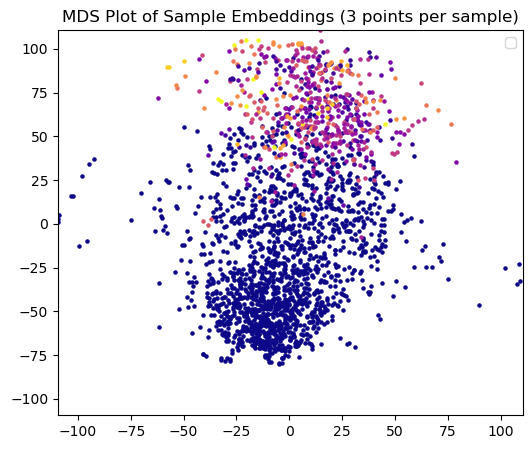

In [191]:
minimum, maximum = np.min(p), np.max(p)
plt.figure(figsize=(6, 5))
plt.title("MDS Plot of Sample Embeddings (3 points per sample)")
for i, group in enumerate(p.reshape((-1, 3, 2))[::-1]):
    plt.scatter(*group.T, s=5, color=c(heat[::-1][i] / max_heat))
plt.xlim((minimum, maximum))
plt.ylim(minimum, maximum)
plt.legend()
plt.show()